# Analizando la serie temporal

In [4]:
import sys, os
sys.path.append(os.path.abspath(os.path.join('..')))
from utils import get_connection_covid_tracking,get_df_sql

[nltk_data] Error loading stopwords: <urlopen error [Errno -3]
[nltk_data]     Temporary failure in name resolution>


In [5]:
import pandas as pd
import numpy as np
import psycopg2
import pandas.io.sql as sqlio

from matplotlib import pyplot as plt
from matplotlib.dates import date2num, num2date
from matplotlib import dates as mdates
from matplotlib import ticker
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch

import statsmodels.api as sm 

from statsmodels.tsa.stattools import adfuller  
from statsmodels.tsa.arima.model import ARIMA   
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, plot_predict
from pandas import plotting as pdplt
from sklearn.preprocessing import MinMaxScaler

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional, RepeatVector, TimeDistributed
from keras.regularizers import L1L2

import datetime

from utils import *
import warnings
warnings.filterwarnings("ignore")

In [6]:
window_size = 7
split_date = '2021-01-01'

In [7]:
#Imprimir resultados del test adf
def print_adf(result):
    print(f'Estadístico ADF: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Valores críticos:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

In [8]:
def plot_prediction(test, prediction, pos=0):
    plt.plot(test[pos:], label='actual no.')
    plt.plot(prediction, label='predicted no.')
    plt.title('Casos confirmados')
    plt.xlabel('días')
    plt.ylabel('nro. de casos')
    plt.legend(fontsize=10)

In [9]:
def return_rmse(test, prediction):
    rmse = math.sqrt(mean_squared_error(test, prediction))
    print(f'RMSE: {rmse}')

In [10]:
def plot_history(history):
    """ Plots to track the history of the metrics """
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(10,4))
    plt.subplot(1,2,1)
    plt.xlabel('epoch')
    plt.ylabel('mse')
    plt.plot(hist['epoch'], hist['mse'], label='train mse')
    plt.plot(hist['epoch'], hist['val_mse'], label='val mse')
    plt.legend()
    
    plt.subplot(1,2,2)
    plt.xlabel('epoch')
    plt.ylabel('mae [%]')
    plt.plot(hist['epoch'], hist['mae']*100., label='train mae')
    plt.plot(hist['epoch'], hist['val_mae']*100., label='val mae')
    plt.legend()

    plt.tight_layout()
    plt.show()
    
    print(f'Predicción MAE: {np.min(hist["mae"].values)*100}%')

In [11]:
#Seleccion de las variables de train y test
def rollingwindow(df, length, splitdate, window_size=7, future=0, flip=False):
    X_train = []
    Y_train = []
    X_test = []
    
    cases_confirmed_serie = pd.Series(df)
    cases_confirmed_serie = cases_confirmed_serie[11:].diff().rolling(window_size).mean().round().dropna()
    cases_confirmed_serie.index = pd.to_datetime(cases_confirmed_serie.index)
    if flip:
        training_data = cases_confirmed_serie['2020-3-15':splitdate].iloc[::-1].values.reshape(-1,1)    
    else:
        training_data = cases_confirmed_serie['2020-3-15':splitdate].values.reshape(-1,1)
    test_data = cases_confirmed_serie[splitdate:].values.reshape(-1,1)

    sc = MinMaxScaler()
    training_data_scaled = sc.fit_transform(training_data)
    
    for i in range(length, training_data.shape[0]-future):
        X_train.append(training_data_scaled[i-length:i, 0])
        if future == 0: Y_train.append(training_data_scaled[i, 0])
        else: Y_train.append(training_data_scaled[i:i+future, 0])
            
    X_train, Y_train = np.array(X_train), np.array(Y_train)
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1],1))
    if future != 0: Y_train = np.reshape(Y_train, (Y_train.shape[0], Y_train.shape[1], 1))

    inputs = cases_confirmed_serie[cases_confirmed_serie.shape[0] - test_data.shape[0] - length:].values
    inputs = inputs.reshape(-1,1)
    inputs = sc.transform(inputs)
    
    for i in range(length, inputs.shape[0]-future):
        X_test.append(inputs[i-length:i, 0])

    X_test = np.array(X_test)
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    return X_train, Y_train, X_test, test_data, sc

--------------------------

### Dataset

In [12]:
sql = f"SELECT * FROM public.get_dataset;"
conn = get_connection_covid_tracking()
dfDataset = get_df_sql(sql,conn)
dfDataset['time_date'] = pd.to_datetime(dfDataset['time_date'])
dfDataset = dfDataset.set_index(['state_name','time_date'])\
                     .squeeze().sort_index()

- Nos centraremos en dar un vistazo general al estado que a día de ayer presentaba el mayor número de casos infectados

In [13]:
lastDate = dfDataset.index.get_level_values('time_date')[-1]
idxMaxCasesConfirmed = dfDataset[dfDataset.index.get_level_values('time_date')== lastDate].squeeze().nlargest(1).index[0][0]
maxConfirmed = dfDataset[dfDataset.index.get_level_values('state_name')== idxMaxCasesConfirmed]
maxConfirmedRolled = maxConfirmed[:].diff()\
                                    .rolling(window_size).mean()\
                                    .round().dropna()

### Análisis de prevalecencia

La prevalencia de una enfermedad cuantifica la proporción de personas en una población que tienen una enfermedad (o cualquier otro suceso) en un determinado momento y proporciona una estimación de la proporción de sujetos de esa población que tenga la enfermedad en ese momento.

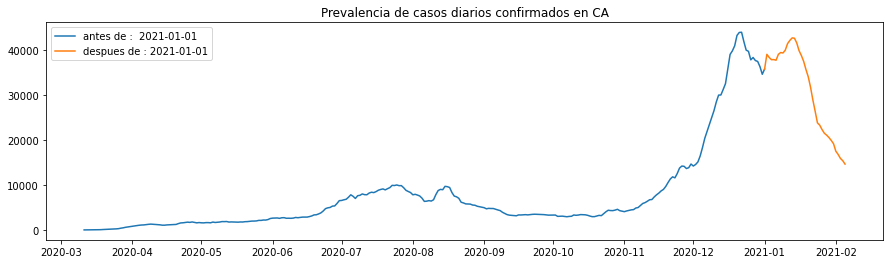

In [14]:
values = maxConfirmedRolled[maxConfirmedRolled.index.get_level_values('time_date') <= split_date]
values2 = maxConfirmedRolled[maxConfirmedRolled.index.get_level_values('time_date') >= split_date]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 1*4))
ax.set_title(f'Prevalencia de casos diarios confirmados en {idxMaxCasesConfirmed}')
ax.plot(values.index.get_level_values('time_date'),values)
ax.plot(values2.index.get_level_values('time_date'),values2)
ax.legend(['antes de :  ' + split_date, 'despues de : ' + split_date])

### Análisis de autocorrelación

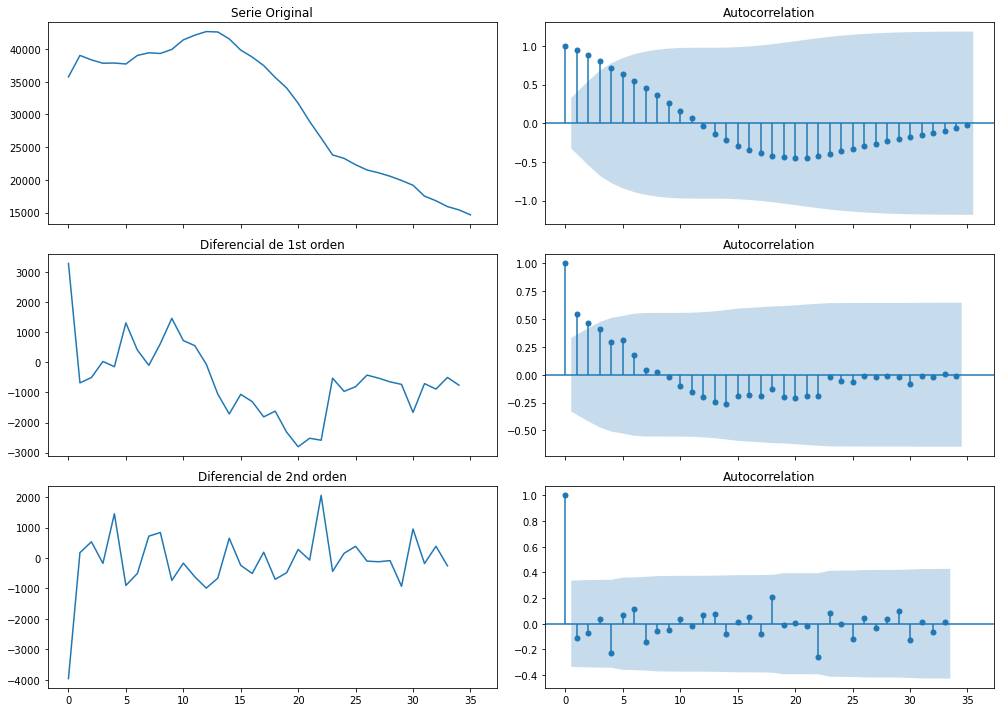

In [15]:
# Original Series
data = maxConfirmedRolled['CA']
a = data[split_date:]
fig, axes = plt.subplots(3, 2, sharex=True, figsize=(14,10))
axes[0, 0].plot(a.values)
axes[0, 0].set_title('Serie Original')
plot_acf(a,
         ax=axes[0, 1],
         lags=a.shape[0]-1)

# # # 1st Differencing
b = a.diff().dropna()
axes[1, 0].plot(b.values)
axes[1, 0].set_title('Diferencial de 1st orden')
plot_acf(b.values, 
         ax=axes[1, 1], 
         lags=b.shape[0]-1)

# # # # 2nd Differencing
c = b.diff().dropna()
axes[2, 0].plot(c.values)
axes[2, 0].set_title('Diferencial de 2nd orden')
plot_acf(c.values, 
         ax=axes[2, 1], 
         lags=c.shape[0]-1)

plt.tight_layout()
plt.show()

### Prueba de raíz unitaria de Dickey-Fuller aumentada.
   - H0: hay una raíz unitaria ,
   - H1: no hay una raíz unitaria. 
    
Los p-values se obtienen mediante la aproximación de la superficie de regresión de (MacKinnon, 1994), utilizando las tablas actualizadas de 2010. 
- Si el p-value está por encima de un tamaño crítico, no podemos rechazar que haya una raíz unitaria.
- Si el valor p está cerca de ser significativo, entonces los valores críticos deben usarse para juzgar si rechazar el nulo.

In [17]:
series_rm = b
adf = adfuller(series_rm.values)
print_adf(adf)

Estadístico ADF: -4.04815227124469
p-value: 0.0011783333848951255
Valores críticos:
	1%: -3.639224104416853
	5%: -2.9512301791166293
	10%: -2.614446989619377


La intuición que se desarrolla detrás del test es que si la serie es caracterizada por un único proceso raíz, entonces el nivel de serie{y_{t-1} no proporcionará información relevante en predecir el cambio en {y_t} además del obtenido en los cambios retardados {Delta y_{t-k} . En este caso {gamma =0} y la hipótesis nula no es rechazada. En contraste, cuando el proceso no tiene raíz unitaria, es estacionario y, por lo tanto, exhibe reversión a la media, por lo que el nivel rezagado proporcionará información relevante para predecir el cambio de la serie y se rechazará la hipótesis nula que existe una raíz unitaria.

Hemos obtenido un p-value = 0.0011783333848951255 Como p-vale < 0.05 => Rechazamos H0 y adoptamos la H1: No existe una raíz única, el proceso es estacionario

### MODELO ARIMA

0:00:05.938704


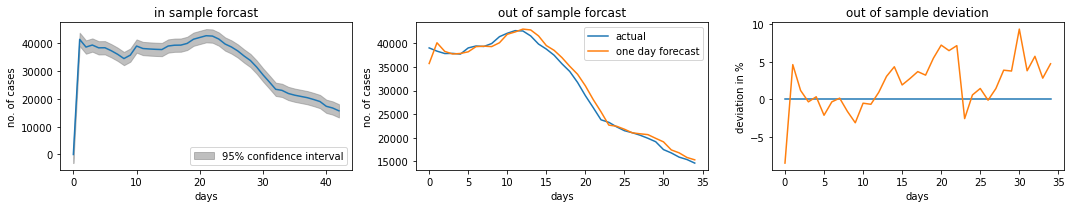

one day forecasting error: 3.13%


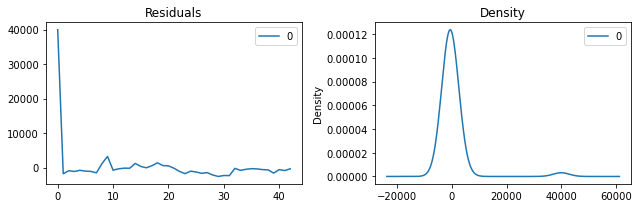

In [149]:
begin_time = datetime.datetime.now()
tdays = a.shape[0]-1

train_days = 42
test_days = 1
indices = list(np.linspace(train_days, train_days+test_days-1, test_days).astype(int))
indices

start_date = str(datetime.datetime.strptime(split_date, '%Y-%m-%d') - datetime.timedelta(days=train_days))[:10]
forecast = []
test_nd = []
acc = []

for i in range(tdays):
    s_date = str(datetime.datetime.strptime(start_date, '%Y-%m-%d') + datetime.timedelta(days=i))[:10]
    e_date = str(datetime.datetime.strptime(split_date, '%Y-%m-%d') + datetime.timedelta(days=i))[:10]
    st_date = str(datetime.datetime.strptime(e_date, '%Y-%m-%d') + datetime.timedelta(days=1))[:10]
    et_date = str(datetime.datetime.strptime(st_date, '%Y-%m-%d') + datetime.timedelta(days=test_days))[:10]
    train = data[s_date:e_date].values
    test = data[st_date:et_date].values

#     # Build Model ARIMA
    model = ARIMA(train, order=(5,1,1))
    fitted = model.fit()

# #     # Forecast
    fc = fitted.forecast(test_days, alpha=0.05)
    conf = fitted.conf_int()
    forecast.append(np.round(fc))
    test_nd.append(np.round(test[0]))
    acc.append((round(fc[0])-round(test[0]))/round(test[0])*100)

# #     # Guardando los datos en una panda series
    fc_series = pd.Series(fc)
    lower_series = pd.Series(conf[:, 0])
    upper_series = pd.Series(conf[:, 1])
    
print(datetime.datetime.now() - begin_time)

fig, ax = plt.subplots(1, 3, figsize=(15,3))
ax[1].plot(test_nd, label='actual')
ax[1].plot(forecast, label='one day forecast')
ax[1].legend(fontsize=10)
ax[1].set_title('out of sample forcast')
ax[1].set_xlabel('days')
ax[1].set_ylabel('no. of cases')
plot_predict(fitted, dynamic=False, ax=ax[0])
ax[0].legend(fontsize=10)
ax[0].set_title('in sample forcast')
ax[0].set_xlabel('days')
ax[0].set_ylabel('no. of cases')
ax[2].plot([0]*len(acc))
ax[2].plot(acc)
ax[2].set_ylabel('deviation in %')
ax[2].set_xlabel('days')
ax[2].set_title('out of sample deviation')
plt.tight_layout()
plt.show()

plt.show()
print('one day forecasting error: {:.2f}%'.format(np.abs(acc).mean()))

residuals = pd.DataFrame(fitted.resid)
fig, ax = plt.subplots(1,2, figsize=(9,3))
residuals.plot(title="Residuals", ax=ax[0])
residuals.plot(kind='kde', title='Density', ax=ax[1])
plt.tight_layout()
plt.show()

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.988
Method:                 Least Squares   F-statistic:                     2859.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           1.22e-33
Time:                        00:59:55   Log-Likelihood:                -292.54
No. Observations:                  35   AIC:                             589.1
Df Residuals:                      33   BIC:                             592.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1008.9905    624.422     -1.616      0.1

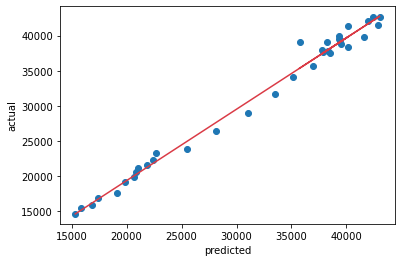

In [152]:
x = forecast
y = test_nd
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
plt.scatter(forecast, test_nd)
plt.plot(x[:,1], results.params[0] + results.params[1]*x[:,1], c='#da3b46')
plt.xlabel('predicted')
plt.ylabel('actual')
print(results.summary())

In [200]:
a = dfDataset[dfDataset.index.get_level_values('state_name')== idxMaxCasesConfirmed]['CA']
X_train, Y_train, X_test, test_data, scaler  = rollingwindow(a, length=5,splitdate=split_date)

### GRU MODEL

In [201]:
length = 14               # length of the past series
maxepochs = 500           # maximum number of epochs
batch_size = 1            # batch size
validation_split = 0.2    # validation split
patience = 5              # patience parameter for the early stopping method

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_8 (GRU)                  (None, 20)                1380      
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 21        
Total params: 1,401
Trainable params: 1,401
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.012908455915749073
********** epochs =  10  val_loss =  0.0014314117142930627
**********Línea base incrementada
 epochs =  20  val_loss =  0.0014701264444738626
***Línea base incrementada
***Línea base incrementada
***Línea base incrementada
* epochs =  30  val_loss =  0.0007141520618461072
*******Línea base incrementada
***
40 : Alcanzó la línea base y finalizó el entrenamiento
Restoring model weights from the end of epoch: 32
 epochs =  40  val_loss =  0.0007276891847141087
*0:00

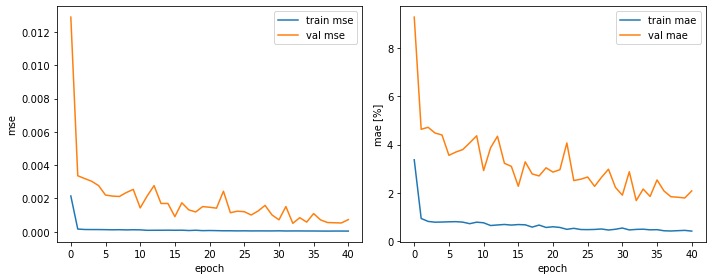

Predicción MAE: 0.4234961234033108%


In [197]:
begin_time = datetime.datetime.now()

time_machine = Sequential()
time_machine.add(GRU(units=20, 
                     activation='tanh', 
                     return_sequences=False, 
                     stateful=False, 
                     bias_regularizer=L1L2(0, 0.05), 
                     input_shape=(X_train.shape[1], X_train.shape[2])))
time_machine.add(Dense(units=1))
time_machine.summary()

time_machine.compile(optimizer='adam', 
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])

history = time_machine.fit(X_train, Y_train,
                           epochs=maxepochs, 
                           batch_size=batch_size, 
                           validation_split=validation_split, 
                           verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', 
                                                          patience=patience, factor=1000), 
                           PrintDots()])
print(datetime.datetime.now() - begin_time)
plot_history(history)

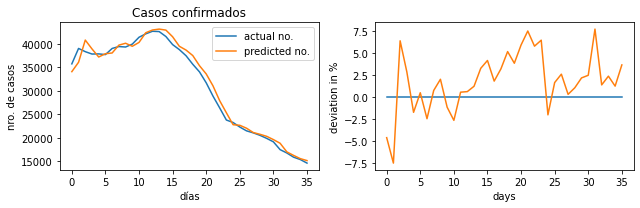

one day forecasting error: 3.09%


In [198]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
predicted_cases = time_machine.predict(X_test)
predicted_cases = scaler.inverse_transform(predicted_cases)
plot_prediction(test_data, np.round(predicted_cases))
plt.subplot(1,2,2)
dev = ((np.round(predicted_cases).T-test_data.T)/test_data.T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.tight_layout()
plt.show()
print('one day forecasting error: {:.2f}%'.format(np.abs(dev).mean()))


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2613.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           9.61e-34
Time:                        01:37:05   Log-Likelihood:                -302.64
No. Observations:                  36   AIC:                             609.3
Df Residuals:                      34   BIC:                             612.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -440.7837    644.309     -0.684      0.4

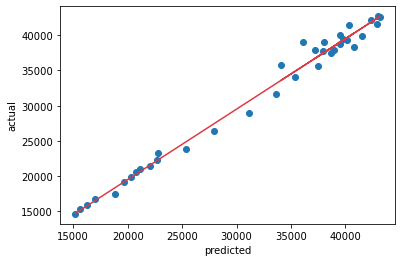

In [199]:
# OLS Test
x = np.round(predicted_cases)
y = test_data
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
plt.scatter(np.round(predicted_cases), test_data)
plt.plot(x[:,1], results.params[0] + results.params[1]*x[:,1], c='#da3b46')
plt.xlabel('predicted')
plt.ylabel('actual')
print(results.summary())

### LSTM

In [213]:
length = 14               # length of the past series
maxepochs = 25           # maximum number of epochs
batch_size = 1            # batch size
validation_split = 0.2    # validation split
patience = 5              # patience parameter for the early stopping method

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 20)                1760      
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 21        
Total params: 1,781
Trainable params: 1,781
Non-trainable params: 0
_________________________________________________________________
 epochs =  0  val_loss =  0.6518463492393494
********** epochs =  10  val_loss =  0.008602404035627842
********** epochs =  20  val_loss =  0.0023708855733275414
*****0:00:26.261439


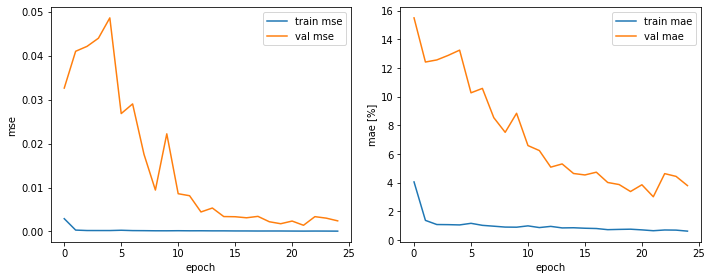

Predicción MAE: 0.6179881747812033%


In [214]:
begin_time = datetime.datetime.now()

time_machine = Sequential()
time_machine.add(LSTM(units=20, 
                     activation='tanh', 
                     return_sequences=False, 
                     stateful=False, 
                     bias_regularizer=L1L2(0, 0.05), 
                     input_shape=(X_train.shape[1], X_train.shape[2])))
time_machine.add(Dense(units=1))
time_machine.summary()

time_machine.compile(optimizer='adam', 
                     loss='mean_squared_error', 
                     metrics=['mse', 'mae'])

history = time_machine.fit(X_train, Y_train,
                           epochs=maxepochs, 
                           batch_size=batch_size, 
                           validation_split=validation_split, 
                           verbose=0,
                           callbacks=[TerminateOnBaseline(monitor='val_loss', 
                                                          patience=patience, factor=1000), 
                           PrintDots()])
print(datetime.datetime.now() - begin_time)
plot_history(history)

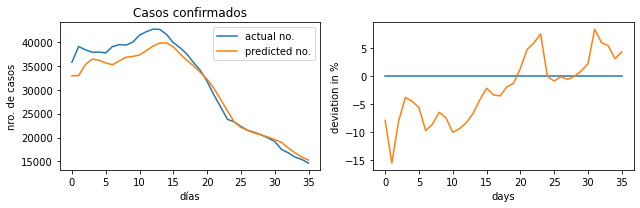

one day forecasting error: 5.01%


In [215]:
plt.figure(figsize=(9,3))
plt.subplot(1,2,1)
predicted_cases = time_machine.predict(X_test)
predicted_cases = scaler.inverse_transform(predicted_cases)
plot_prediction(test_data, np.round(predicted_cases))
plt.subplot(1,2,2)
dev = ((np.round(predicted_cases).T-test_data.T)/test_data.T*100)
plt.plot([0]*dev.shape[1])
plt.plot(dev[0])
plt.ylabel('deviation in %')
plt.xlabel('days')
plt.tight_layout()
plt.show()
print('one day forecasting error: {:.2f}%'.format(np.abs(dev).mean()))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.980
Model:                            OLS   Adj. R-squared:                  0.979
Method:                 Least Squares   F-statistic:                     1631.
Date:                Sun, 07 Feb 2021   Prob (F-statistic):           2.55e-30
Time:                        01:50:44   Log-Likelihood:                -310.98
No. Observations:                  36   AIC:                             626.0
Df Residuals:                      34   BIC:                             629.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -3846.7255    896.318     -4.292      0.0

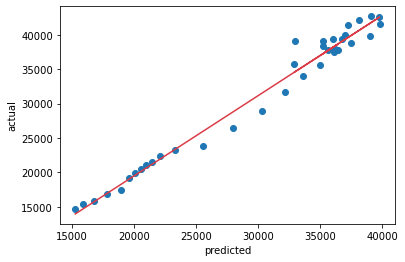

In [216]:
# OLS Test
x = np.round(predicted_cases)
y = test_data
x = sm.add_constant(x)
model = sm.OLS(y, x)
results = model.fit()
plt.scatter(np.round(predicted_cases), test_data)
plt.plot(x[:,1], results.params[0] + results.params[1]*x[:,1], c='#da3b46')
plt.xlabel('predicted')
plt.ylabel('actual')
print(results.summary())